## Installs, imports and Boilerplate code

In [0]:
import warnings
warnings.filterwarnings(action='once')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Convolution2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.utils import np_utils
from keras import backend as K

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py:5747: ResourceWarning: unclosed file <_io.TextIOWrapper name='/root/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  ret

In [0]:
# loading and configuring cifar10 dataset
from keras.datasets import cifar10

# x_train/test : train/test features
# y_train/test : train/test labels
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols = x_train.shape
num_test = x_test.shape[0]
num_classes = len(np.unique(y_train))

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat',  
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
# https://stackoverflow.com/questions/45965007/multiline-f-string-in-python
print(f"""Train images : {num_train}
Test images : {num_test}
Total classes : {num_classes}
Input image shape : {x_train.shape[1:]}
""")

Train images : 50000
Test images : 10000
Total classes : 10
Input image shape : (32, 32, 3)



In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.03 * 1/(1 + 0.319 * epoch), 10)

In [0]:
def plot_model_history(model_history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  # summarize history for accuracy
  ax[0].plot(range(1, len(model_history.history['acc'])+1), model_history.history['acc'])#, label='Training Acc')
  ax[0].plot(range(1, len(model_history.history['val_acc'])+1), model_history.history['val_acc'])#, label='Validation Acc')
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xticks(np.arange(1, len(model_history.history['acc'])+1), len(model_history.history['acc'])/10)
  ax[0].legend(['Train', 'Validation'], loc='best')

  # summarize history for loss
  ax[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
  ax[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
  ax[1].legend(['Train', 'Validation'], loc='best')

  plt.show()

In [0]:
def accuracy(test_x, test_y, model):
  result = model.predict(test_x)
  predicted = np.argmax(result, axis=1)
  true = np.argmax(test_y, axis=1)
  num_correct = np.sum(predicted == true)
  accuracy = float(num_correct)/result.shape[0]
  return (accuracy * 100)

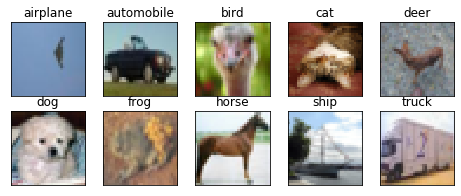

In [0]:
# Checking images, one for each class
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
  ax = fig.add_subplot(2, 5, 1+i, xticks=[], yticks=[])
  idx = np.where(y_train[:]==i)[0]  # selecting all images of a class
  features = x_train[idx,::]
  img_num = np.random.randint(features.shape[0]) # selecting random no. from class idx
  im = features[img_num]  # selecting features of the image from random no.
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

In [0]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# converting class labels to one hot encoded
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

## Model

In [0]:
# Define the model
model = Sequential() 
model.add(SeparableConv2D(32, 3, use_bias=False, input_shape=(32, 32, 3))) # 30x3x3x32 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))

model.add(SeparableConv2D(64, 3, use_bias=False)) # 28x3x3x64 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))

model.add(MaxPooling2D(2)) # 14x3x3x128
model.add(Convolution2D(32, 1, use_bias=False))  # 14x3x3x32

model.add(SeparableConv2D(32, 3, use_bias=False)) # 12x3x3x128 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(SeparableConv2D(64, 3, use_bias=False)) # 10x3x3x256 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(2)) # 5x3x3x64
model.add(Convolution2D(32, 1, use_bias=False))  # 5x3x3x32

model.add(SeparableConv2D(32, 3, use_bias=False)) # 3x3x3x32 RF:3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(SeparableConv2D(10, 3, use_bias=False)) # 1x3x3x10 RF:3
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D()) # 1X10
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_6 (Separabl (None, 30, 30, 32)        123       
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
separable_conv2d_7 (Separabl (None, 28, 28, 64)        2336      
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)       

In [0]:
# Compile the model
model.compile(optimizer=Adam(lr=0.03), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

In [0]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 50, 
                                 validation_data = (x_test, y_test),callbacks=[LearningRateScheduler(scheduler, verbose=1)], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=50)`
  """


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.03.
390/390 [==============================] - 26s 67ms/step - loss: 1.6474 - acc: 0.3937 - val_loss: 3.2513 - val_acc: 0.2712
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0227445034.
390/390 [==============================] - 23s 59ms/step - loss: 1.3264 - acc: 0.5200 - val_loss: 1.5750 - val_acc: 0.4674
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0183150183.
390/390 [==============================] - 23s 59ms/step - loss: 1.1634 - acc: 0.5853 - val_loss: 1.2581 - val_acc: 0.5690
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0153295861.
390/390 [==============================] - 23s 59ms/step - loss: 1.0567 - acc: 0.6261 - val_loss: 1.1555 - val_acc: 0.6014
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0131810193.
390/390 [==============================] - 23s 58ms/step - loss: 0.9810 - acc: 0.6527 

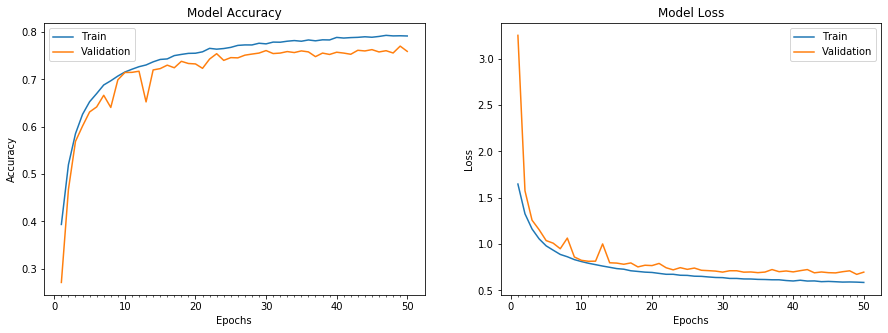

In [0]:
# plot model history
plot_model_history(model_info)

In [0]:
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model))

Accuracy on test data is: 75.91
